In [1]:
import re
import pandas as pd
import numpy as np
import h5py
import torch
from torch.utils.data import Dataset
from scipy.signal import butter, filtfilt, resample
from typing import Tuple
import matplotlib.pyplot as plt

from BedrettoDataset import BedrettoDataset
from phasenet import PhaseNet
import eval_utils 
import sys 
sys.path.append("..")

### Training

In [2]:
torch.manual_seed(120)
dataset = BedrettoDataset(csv_file='..//data//Bedretto_metadata.csv', h5_file='..//data//Bedretto_waveforms.hdf5', width=6000,tri_width = 30, allow_missing_s=False, slack=0)
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [int(len(dataset)*0.8), len(dataset)-int(len(dataset)*0.8)])

batch_size = 64
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=10, persistent_workers=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=10, persistent_workers=True)

In [16]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if torch.backends.mps.is_available():
    device = torch.device("mps")
    
model = PhaseNet().to(device)

epochs = 10
learning_rate = 0.0001

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
criterion = torch.nn.CrossEntropyLoss(reduction='sum')

In [ ]:
epochs = 40
model.to(device)

In [17]:
# Training loop
for epoch in range(epochs):
    model.train()
    train_loss = 0
    for i, (inputs, labels) in enumerate(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs, logits=True) #inputs[:, 0, :]
    
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        with torch.no_grad():
            train_loss += loss.cpu().detach().numpy() / inputs.shape[0]


    if (epoch%10 == 9): 
        print(f"End of Epoch {epoch+1} mean training loss {train_loss / len(train_loader)}")
    
        val_loss = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs, logits=True) #inputs[:, 0, :]
                
                val_loss += criterion(outputs, labels) / inputs.shape[0]
            
            print(f'Validation loss for epoch {epoch+1}: ', val_loss / len(val_loader))

End of Epoch 10 mean training loss 2618.659887313843
Validation loss for epoch 10:  tensor(2491.1143, device='mps:0')


### Semi-Supervised approach
1. Train model solely on waves where P and S are both labeled ("allow_missing_S = False" in BedrettoDataset() call, also use full dataset for training, i.e. no val set)
2. Create a new Bedretto metadata file by e.g. using the codeblock below with the newly trained model
3. Train a new model on the new metadata ("csv_file='..//data//Bedretto_metadata_filled.csv' in BedrettoDataset() call)

In [ ]:
# model : a model trained only on the P and S labeled waves of Bedretto
df = pd.read_csv('..//data//Bedretto_metadata.csv')

for i in range(len(df)):
    p_arrival = df.iloc[i]['trace_p_arrival_sample']
    s_arrival = df.iloc[i]['trace_s_arrival_sample']
    
    if (pd.isna(s_arrival) and (not pd.isna(p_arrival))):
        inputs, labels = dataset[i]
        outputs = model(inputs.unsqueeze(0), logits=False)
        s_pred = np.argmax(outputs[0, 1, :].detach().numpy())
        df.at[i, 'trace_s_arrival_sample'] = s_pred + p_arrival - 500
        
        
df.to_csv('..//data//Bedretto_metadata_filled.csv')

### Eval Stuff

In [8]:
#torch.save(model, 'classification_models// .pt')

In [25]:
model = torch.load('classification_models//BedrModel_SemiSupervised.pt')

In [26]:
model.to('cpu')
evaluator = eval_utils.ClassificationEvaluator(model, val_loader, wave_length=6000, pretrained=False, batch_size=64)

In [27]:
evaluator.f1score()

(tensor(0.9847), tensor(0.8167))

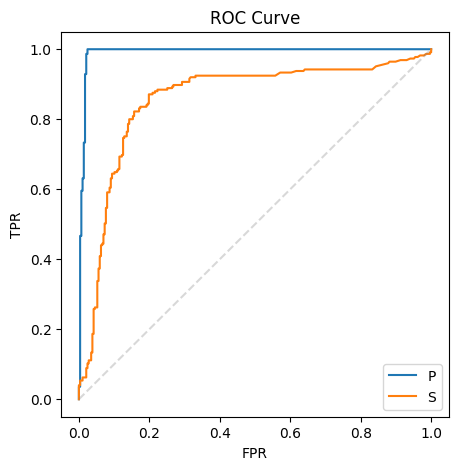

In [28]:
evaluator.roc_curve(num_thetas=100000)

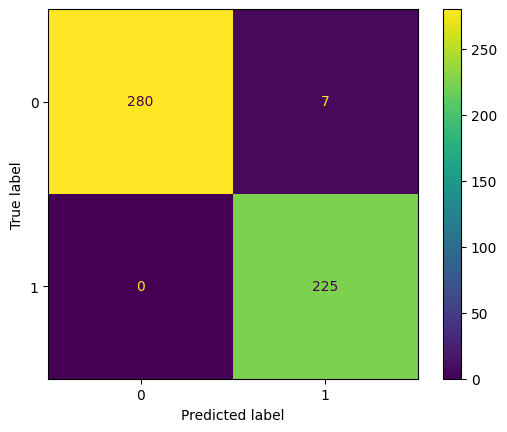

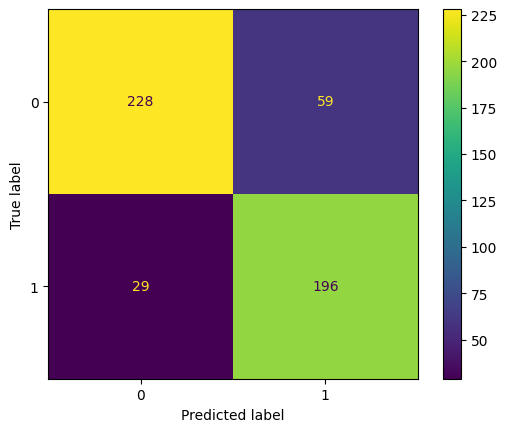

In [29]:
evaluator.plot_confusion_matrix()

/Users/rob/Documents/GitHub/earthquake-monitoring/classification/eval_utils.py:155: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


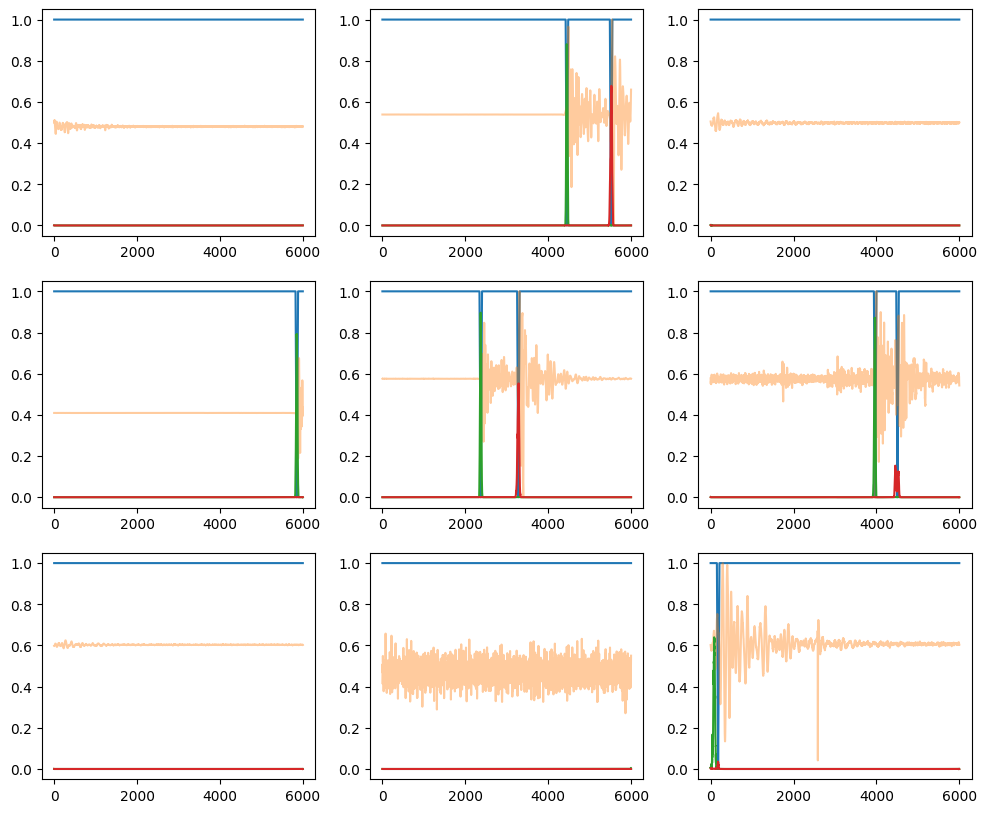

In [30]:
evaluator.plot_preds(3, offset=30)